In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[2]")\
    .appName("Lesson_4")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

21/09/08 21:06:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.feature import HashingTF, Tokenizer, Normalizer, VectorAssembler, StringIndexer, MinMaxScaler, VectorIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import Window
import matplotlib.pyplot as plt

# Данные:
[скачать](https://drive.google.com/file/d/1MuAyZiIm3b_r-AgQSj78tsRPqZpvv_2s/view?usp=sharing)

**application_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   CODE_GENDER	Gender	
*   FLAG_OWN_CAR	Is there a car	
*   FLAG_OWN_REALTY	Is there a property	
*   CNT_CHILDREN	Number of children	
*   AMT_INCOME_TOTAL	Annual income	
*   NAME_INCOME_TYPE	Income category	
*   NAME_EDUCATION_TYPE	Education level	
*   NAME_FAMILY_STATUS	Marital status	
*   NAME_HOUSING_TYPE	Way of living	
*   DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday
*   DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
FLAG_MOBIL	Is there a mobile phone	
*   FLAG_WORK_PHONE	Is there a work phone	
*   FLAG_PHONE	Is there a phone	
*   FLAG_EMAIL	Is there an email	
*   OCCUPATION_TYPE	Occupation	
*   CNT_FAM_MEMBERS	Family size	

**credit_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   MONTHS_BALANCE	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
*   STATUS	Status	
   *   0: 1-29 days past due
   *   1: 30-59 days past due 
   *   2: 60-89 days overdue 
   *   3: 90-119 days overdue 
   *   4: 120-149 days overdue 
    *   5: Overdue or bad debts, write-offs for more than 150 days
    *   C: paid off that month X: No loan for the month

In [3]:
# Ниже, мы для тех, у кого хоть раз были просрчоки больше 60 дней, ставим в таргет 1.
data = spark.read.csv('application_record.csv', encoding = 'utf-8', header=True, inferSchema=True, sep=',')
record = spark.read.csv('credit_record.csv', encoding = 'utf-8', header=True, inferSchema=True, sep=',')
data.printSchema()
data.count()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



438557

In [4]:
record.printSchema()
record.count()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



1048575

In [5]:
# Добавляем срок кредита к параметрам выдачи кредита
begin_month  = record.groupBy('ID').agg((F.min('MONTHS_BALANCE')*(-1)).alias('begin_month'))
begin_month.printSchema()
begin_month.show(5)
begin_month.count()

root
 |-- ID: integer (nullable = true)
 |-- begin_month: integer (nullable = true)



+-------+-----------+
|     ID|begin_month|
+-------+-----------+
|5001812|         22|
|5001849|          8|
|5001921|         19|
|5003338|         33|
|5003386|          7|
+-------+-----------+
only showing top 5 rows



45985

In [6]:
new_data = data.join(begin_month, on= 'ID', how = 'left')\
                .select('*')
new_data.printSchema()
new_data.show()
new_data.count()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- begin_month: integer (nullable = true)



+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|begin_month|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment

438557

In [7]:
# Добавляем есть ли просрочка к параметрам выдачи кредита
# # Больше 60, то это просрочка, ставим - Yes, если просрочка есть за срок кредита,то так же ставим Yes
# record['dep_value'] = None
# record['dep_value'][record['STATUS'] == '2'] = 'Yes'
# record['dep_value'][record['STATUS'] == '3'] = 'Yes'
# record['dep_value'][record['STATUS'] == '4'] = 'Yes'
# record['dep_value'][record['STATUS'] == '5'] = 'Yes'
# cpunt = record.groupby('ID').count()
# cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes' 
# cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'

@F.udf(IntegerType())
def dep_value(value): # функция есть или нет просрочка, на выходе "yes" или "no" 
    if value == '2' or value == '3' or value == '4' or value == '5':
        res = 1
    elif  value == '0' or value == '1' or value == 'C' or value == 'X':
         res = 0
    return res

record = record.withColumn('dep_value', dep_value(F.col('STATUS')).cast(IntegerType()))
record.printSchema()
record.show()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- dep_value: integer (nullable = true)



+-------+--------------+------+---------+
|     ID|MONTHS_BALANCE|STATUS|dep_value|
+-------+--------------+------+---------+
|5001711|             0|     X|        0|
|5001711|            -1|     0|        0|
|5001711|            -2|     0|        0|
|5001711|            -3|     0|        0|
|5001712|             0|     C|        0|
|5001712|            -1|     C|        0|
|5001712|            -2|     C|        0|
|5001712|            -3|     C|        0|
|5001712|            -4|     C|        0|
|5001712|            -5|     C|        0|
|5001712|            -6|     C|        0|
|5001712|            -7|     C|        0|
|5001712|            -8|     C|        0|
|5001712|            -9|     0|        0|
|5001712|           -10|     0|        0|
|5001712|           -11|     0|        0|
|5001712|           -12|     0|        0|
|5001712|           -13|     0|        0|
|5001712|           -14|     0|        0|
|5001712|           -15|     0|        0|
+-------+--------------+------+---

Traceback (most recent call last):                                              
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [8]:
cpunt = record.groupBy('ID').agg((F.sum('dep_value')).alias('dep_value'))
cpunt.printSchema()
cpunt.show(5)

root
 |-- ID: integer (nullable = true)
 |-- dep_value: long (nullable = true)



+-------+---------+
|     ID|dep_value|
+-------+---------+
|5001812|        0|
|5001849|        0|
|5001921|        0|
|5003338|        0|
|5003386|        0|
+-------+---------+
only showing top 5 rows



In [9]:
@F.udf(IntegerType())
def dep_value2(value): # функция есть или нет просрочка, на выходе "yes" или "no" 
    if value > 0:
        res = 1
    elif  value == 0:
         res = 0
    return res
cpunt = cpunt.withColumn('target', dep_value2(F.col('dep_value')).cast(IntegerType()))

In [10]:
cpunt = cpunt.select('ID','target')
cpunt.printSchema()
cpunt.where(F.col('target') == 1).show(5)

root
 |-- ID: integer (nullable = true)
 |-- target: integer (nullable = true)



+-------+------+
|     ID|target|
+-------+------+
|5023641|     1|
|5116036|     1|
|5116679|     1|
|5146444|     1|
|5021383|     1|
+-------+------+
only showing top 5 rows



In [11]:
cpunt.count()

45985

In [12]:
# # Джойним все вместе(cpunt и new_data)
# cpunt = cpunt[['dep_value']]
# new_data = pd.merge(new_data, cpunt, how='inner', on='ID')
new_data = new_data.join(cpunt, on= 'ID', how = 'inner')\
                .select('*')
new_data.printSchema()
new_data.show(5)
new_data.count()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- begin_month: integer (nullable = true)
 |-- target: integer (nullable = true)



+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|begin_month|target|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marri

36457

In [13]:
#  В итоге к анкетным данным мы добавили таргет
new_data.head()

Row(ID=5008804, CODE_GENDER='M', FLAG_OWN_CAR='Y', FLAG_OWN_REALTY='Y', CNT_CHILDREN=0, AMT_INCOME_TOTAL=427500.0, NAME_INCOME_TYPE='Working', NAME_EDUCATION_TYPE='Higher education', NAME_FAMILY_STATUS='Civil marriage', NAME_HOUSING_TYPE='Rented apartment', DAYS_BIRTH=-12005, DAYS_EMPLOYED=-4542, FLAG_MOBIL=1, FLAG_WORK_PHONE=1, FLAG_PHONE=0, FLAG_EMAIL=0, OCCUPATION_TYPE=None, CNT_FAM_MEMBERS=2.0, begin_month=15, target=0)

In [14]:
# Упростим себе задачу и оставим толькo часть признаков
new_data = new_data.select('AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'target')
new_data.printSchema()
new_data.show(5)
new_data.count()

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- target: integer (nullable = true)



+----------------+-----------+------------+---------------+------------+------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|
+----------------+-----------+------------+---------------+------------+------+
|        427500.0|          M|           Y|              Y|           0|     0|
|        427500.0|          M|           Y|              Y|           0|     0|
|        112500.0|          M|           Y|              Y|           0|     0|
|        270000.0|          F|           N|              Y|           0|     0|
|        270000.0|          F|           N|              Y|           0|     0|
+----------------+-----------+------------+---------------+------------+------+
only showing top 5 rows



36457

In [15]:
# Давайте так же глянем корреляции (у численных)
# И мы наблюдаем, что корреляции почти нет
features_corr_vector = VectorAssembler(inputCols = ['AMT_INCOME_TOTAL','CNT_CHILDREN', 'target'], outputCol = 'features_corr_vector')
new_data_corr = features_corr_vector.transform(new_data)
corr = Correlation.corr(new_data_corr, 'features_corr_vector').collect()
print(corr)

21/09/08 21:07:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/09/08 21:07:29 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


[Row(pearson(features_corr_vector)=DenseMatrix(3, 3, [1.0, 0.0337, -0.0011, 0.0337, 1.0, -0.0003, -0.0011, -0.0003, 1.0], False))]


In [16]:
new_data2 = new_data.withColumn('label', F.col('target')).select('AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'label')
new_data2.printSchema()

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- label: integer (nullable = true)



У нас есть выборка, где указаны параметры клиента, и вышел ли он на просрочку или нет.

Дальше будем исследовать, есть ли связь между этими параметрами и возвратом кредита.

Можете уже на этом этапе предложить гипотезы, а мы их проверим. Предположим, что чем больше детей, тем меньше вероятность, что будет просрочка.

In [17]:
# Превращаем категориальные факторы 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY' в численные
gender_indexer =  StringIndexer(inputCol = 'CODE_GENDER', outputCol = 'CODE_GENDER_INDEX')

car_indexer =  StringIndexer(inputCol = 'FLAG_OWN_CAR', outputCol = 'FLAG_OWN_CAR_INDEX')

realty_indexer = StringIndexer(inputCol = 'FLAG_OWN_REALTY', outputCol = 'FLAG_OWN_REALTY_INDEX')

onehotencoder_gender_vector = OneHotEncoder(inputCol='CODE_GENDER_INDEX', outputCol='CODE_GENDER_VEC')

onehotencoder_car_vector = OneHotEncoder(inputCol='FLAG_OWN_CAR_INDEX', outputCol='FLAG_OWN_CAR_VEC')

onehotencoder_realty_vector = OneHotEncoder(inputCol='FLAG_OWN_REALTY_INDEX', outputCol='FLAG_OWN_REALTY_VEC')

pipeline1 = Pipeline(stages=[gender_indexer, car_indexer, realty_indexer, onehotencoder_gender_vector, onehotencoder_car_vector, onehotencoder_realty_vector])
new_data3 = pipeline1.fit(new_data2).transform(new_data2)

In [18]:
new_data3.show(5, truncate = False, vertical = True)

-RECORD 0------------------------------
 AMT_INCOME_TOTAL      | 427500.0      
 CODE_GENDER           | M             
 FLAG_OWN_CAR          | Y             
 FLAG_OWN_REALTY       | Y             
 CNT_CHILDREN          | 0             
 label                 | 0             
 CODE_GENDER_INDEX     | 1.0           
 FLAG_OWN_CAR_INDEX    | 1.0           
 FLAG_OWN_REALTY_INDEX | 0.0           
 CODE_GENDER_VEC       | (1,[],[])     
 FLAG_OWN_CAR_VEC      | (1,[],[])     
 FLAG_OWN_REALTY_VEC   | (1,[0],[1.0]) 
-RECORD 1------------------------------
 AMT_INCOME_TOTAL      | 427500.0      
 CODE_GENDER           | M             
 FLAG_OWN_CAR          | Y             
 FLAG_OWN_REALTY       | Y             
 CNT_CHILDREN          | 0             
 label                 | 0             
 CODE_GENDER_INDEX     | 1.0           
 FLAG_OWN_CAR_INDEX    | 1.0           
 FLAG_OWN_REALTY_INDEX | 0.0           
 CODE_GENDER_VEC       | (1,[],[])     
 FLAG_OWN_CAR_VEC      | (1,[],[])     


In [19]:
# Разделим выборку на трейн и тест, на трейн будем обучать модель, на тест валидировать.
# плюс валидация и train и test
train, test = new_data3.randomSplit([0.7, 0.3])

In [20]:
income_children_vector = VectorAssembler(inputCols = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN'], outputCol = 'income_children_vector')
train_transformed = income_children_vector.transform(train)
train_transformed.printSchema()
train_transformed.show(1)

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- CODE_GENDER_INDEX: double (nullable = false)
 |-- FLAG_OWN_CAR_INDEX: double (nullable = false)
 |-- FLAG_OWN_REALTY_INDEX: double (nullable = false)
 |-- CODE_GENDER_VEC: vector (nullable = true)
 |-- FLAG_OWN_CAR_VEC: vector (nullable = true)
 |-- FLAG_OWN_REALTY_VEC: vector (nullable = true)
 |-- income_children_vector: vector (nullable = true)



+----------------+-----------+------------+---------------+------------+-----+-----------------+------------------+---------------------+---------------+----------------+-------------------+----------------------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|label|CODE_GENDER_INDEX|FLAG_OWN_CAR_INDEX|FLAG_OWN_REALTY_INDEX|CODE_GENDER_VEC|FLAG_OWN_CAR_VEC|FLAG_OWN_REALTY_VEC|income_children_vector|
+----------------+-----------+------------+---------------+------------+-----+-----------------+------------------+---------------------+---------------+----------------+-------------------+----------------------+
|         27000.0|          F|           N|              Y|           0|    0|              0.0|               0.0|                  0.0|  (1,[0],[1.0])|   (1,[0],[1.0])|      (1,[0],[1.0])|         [27000.0,0.0]|
+----------------+-----------+------------+---------------+------------+-----+-----------------+------------------+---------------------+-------

In [21]:
test_transformed = income_children_vector.transform(test)
test_transformed.count()

10980

In [22]:
# Отскалируем численные 'AMT_INCOME_TOTAL', 'CNT_CHILDREN'
mms = MinMaxScaler(inputCol = 'income_children_vector', outputCol = 'income_children_vector_SCALED')
train = mms.fit(train_transformed).transform(train_transformed)
test = mms.fit(train_transformed).transform(train_transformed)

In [23]:
train.select('income_children_vector', 'income_children_vector_SCALED').show(5, truncate = False)

+----------------------+-----------------------------+
|income_children_vector|income_children_vector_SCALED|
+----------------------+-----------------------------+
|[27000.0,0.0]         |(2,[],[])                    |
|[29250.0,0.0]         |[0.0014534883720930235,0.0]  |
|[29250.0,0.0]         |[0.0014534883720930235,0.0]  |
|[29250.0,0.0]         |[0.0014534883720930235,0.0]  |
|[30150.0,0.0]         |[0.0020348837209302325,0.0]  |
+----------------------+-----------------------------+
only showing top 5 rows



In [24]:
# формируем вектор(список) features из данных отдельных колонок
features_vector = VectorAssembler(inputCols = ['income_children_vector_SCALED', 'CODE_GENDER_VEC', 'FLAG_OWN_CAR_VEC', 'FLAG_OWN_REALTY_VEC'], outputCol = 'features_sparse_vector')
train = features_vector.transform(train)
train.printSchema()
train.select('income_children_vector_SCALED', 'CODE_GENDER_VEC', 'FLAG_OWN_CAR_VEC', 'FLAG_OWN_REALTY_VEC', 'features_sparse_vector').show(1, vertical = True)
test = features_vector.transform(test)
test.printSchema()

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- CODE_GENDER_INDEX: double (nullable = false)
 |-- FLAG_OWN_CAR_INDEX: double (nullable = false)
 |-- FLAG_OWN_REALTY_INDEX: double (nullable = false)
 |-- CODE_GENDER_VEC: vector (nullable = true)
 |-- FLAG_OWN_CAR_VEC: vector (nullable = true)
 |-- FLAG_OWN_REALTY_VEC: vector (nullable = true)
 |-- income_children_vector: vector (nullable = true)
 |-- income_children_vector_SCALED: vector (nullable = true)
 |-- features_sparse_vector: vector (nullable = true)



-RECORD 0---------------------------------------------
 income_children_vector_SCALED | (2,[],[])            
 CODE_GENDER_VEC               | (1,[0],[1.0])        
 FLAG_OWN_CAR_VEC              | (1,[0],[1.0])        
 FLAG_OWN_REALTY_VEC           | (1,[0],[1.0])        
 features_sparse_vector        | [0.0,0.0,1.0,1.0,... 
only showing top 1 row

root
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- CODE_GENDER_INDEX: double (nullable = false)
 |-- FLAG_OWN_CAR_INDEX: double (nullable = false)
 |-- FLAG_OWN_REALTY_INDEX: double (nullable = false)
 |-- CODE_GENDER_VEC: vector (nullable = true)
 |-- FLAG_OWN_CAR_VEC: vector (nullable = true)
 |-- FLAG_OWN_REALTY_VEC: vector (nullable = true)
 |-- income_children_vector: vector (nullable = true)
 |-- income_children_

In [25]:
def sparse_to_array(vector):
    vector = DenseVector(vector)
    new_array = list([float(x) for x in vector])
    return new_array

sparse_to_array_udf = F.udf(sparse_to_array, ArrayType(FloatType()))

In [26]:
train = train.withColumn('features_array', sparse_to_array_udf(F.col('features_sparse_vector')))

In [27]:
train.select('features_sparse_vector', 'features_array').show(truncate = False)

+---------------------------------------+----------------------------------+
|features_sparse_vector                 |features_array                    |
+---------------------------------------+----------------------------------+
|[0.0,0.0,1.0,1.0,1.0]                  |[0.0, 0.0, 1.0, 1.0, 1.0]         |
|[0.0014534883720930235,0.0,1.0,0.0,1.0]|[0.0014534884, 0.0, 1.0, 0.0, 1.0]|
|[0.0014534883720930235,0.0,1.0,0.0,1.0]|[0.0014534884, 0.0, 1.0, 0.0, 1.0]|
|[0.0014534883720930235,0.0,1.0,0.0,1.0]|[0.0014534884, 0.0, 1.0, 0.0, 1.0]|
|[0.0020348837209302325,0.0,0.0,1.0,1.0]|[0.0020348837, 0.0, 0.0, 1.0, 1.0]|
|[0.002906976744186047,0.0,1.0,1.0,0.0] |[0.0029069767, 0.0, 1.0, 1.0, 0.0]|
|(5,[0,2],[0.002906976744186047,1.0])   |[0.0029069767, 0.0, 1.0, 0.0, 0.0]|
|(5,[0,2],[0.002906976744186047,1.0])   |[0.0029069767, 0.0, 1.0, 0.0, 0.0]|
|(5,[0,2],[0.002906976744186047,1.0])   |[0.0029069767, 0.0, 1.0, 0.0, 0.0]|
|(5,[0,2],[0.002906976744186047,1.0])   |[0.0029069767, 0.0, 1.0, 0.0, 0.0]|

In [28]:
test = test.withColumn('features_array', sparse_to_array_udf(F.col('features_sparse_vector')))
test.count()

25477

#  Модель

Модель будет находить коэффициенты alpha и beta, где Х наши колонки/факторы. Погуглите подробнее, но данная формула даёт вероятность события.

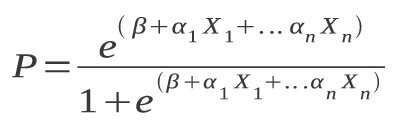

In [29]:
# Создадим простейшую модель, которая покажет через линейные коэффиценты связь переменных и таргета
lr = LogisticRegression()
tf = HashingTF(inputCol= 'features_array', outputCol= 'features')
pipe = Pipeline(stages=[tf, lr])
lr_model = pipe.fit(train)

In [30]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = lr_model.transform(test)
selected = prediction.select('label', 'features', 'rawPrediction', 'probability', 'prediction')
selected.printSchema()
selected.show()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(262144,[52281,24...|[8.72181143990360...|[0.99983703488823...|       0.0|
|    0|(262144,[11726,52...|[42.4606504360674...|           [1.0,0.0]|       0.0|
|    0|(262144,[11726,52...|[42.4606504360674...|           [1.0,0.0]|       0.0|
|    0|(262144,[11726,52...|[42.4606504360674...|           [1.0,0.0]|       0.0|
|    0|(262144,[23536,52...|[42.4605391662358...|           [1.0,0.0]|       0.0|
|    0|(262144,[48272,52...|[42.6818145693993...|           [1.0,0.0]|       0.0|
|    0|(262144,[48272,52...|[42.5789170024753...|           [1.0,0.0]|       0.0|
|    0|(262144,[48272,52...|[42.5789170024753...|           [1.0,0.0]|       0.0|
|    0|(262144,[48272,52...|[42.5789170024753...|           [1.0,0.0]|       0.0|
|    0|(262144,[

In [31]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(prediction))

0.6462391101393847


In [32]:
# точность модели
accuracy = prediction.filter(prediction.label == prediction.prediction).count() / float(prediction.count())
print("Accuracy : ", accuracy)

Accuracy :  0.9837500490638615
